# 底层功能介绍
2019-5-12

### client 类使用方法
请按照这个note book 走一遍，因为我只是测试了在我的电脑上能运行，不确保再其它的设备上没有各种莫名其妙的问题，因为两个程序之间的交互涉及到了endian 的问题，传输buffer的问题，以及内存对齐的问题，吃了不少屎。所以做后续实验前请先测试这里的步骤都没问题。

使用前请运行qtcyberdip，连接机器人和摄像头

In [6]:
from CyClient import *

In [66]:
cli = Client()

In [4]:
#检查udp基本交互
cli.sayHello() #received:  Hello From Server

received:     Hello From Server 


In [5]:
#检查机器人控制
cli.takAction(0,5,5)# 相对移动五五

received:     M         0         5         5


In [6]:
cli.takAction(1,0,0)# 绝对移动00

received:     M         1         0         0


In [7]:
cli.takAction(2,0,0)# 点

received:     M         2         0         0


In [8]:
cli.takAction(4,0,0)# 放

received:     M         4         0         0


In [9]:
cli.takAction(3,0,0)#抬

received:     M         3         0         0


In [10]:
cli.getPos() # current X pos, Y pos, isdown 

received: 
(0.0, 0.0, 0)


(0.0, 0.0, 0)

received: 
600 800 3
30000


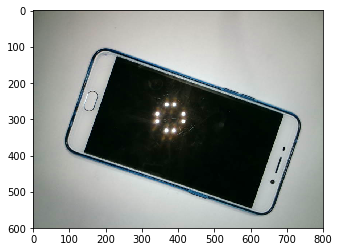

In [146]:
#检查读入图片
plt.imshow(cli.getPic())
plt.show()

received: 
600 800 3
30000


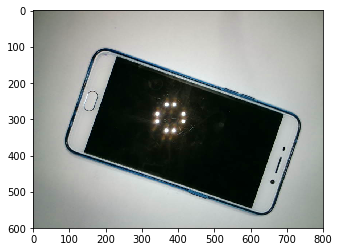

In [147]:
pic = cli.getPic()
plt.imshow(pic)
plt.show()

## 自动旋转矫正功能
有了这个功能之后，略加截取就可以得到手机屏幕
但是现在开发的效果比较不稳定，也许换一个matcher会好些

##### 但我觉得这个思路是可以成功的

In [1]:
from rawProcessing import *
#plt.imshow(TurnWindow(pic))
#plt.show()

#### 在我自己开发算法时使用的小小的数据集是能用的

In [2]:
import os
imagedir = "pics"
# imagedir = "images"

dirs = os.listdir(imagedir)
pics = []
for file in dirs:
    x = cv2.imread(os.path.join(imagedir,file))
#     print(x[0])
#     x[:,:,2],x[:,:,1] = x[:,:,1],x[:,:,2]
    pics.append(x)

def toAllImg(func,*args):
    for p in pics[1:len(pics)]:
        plt.subplot(1,2,1),plt.imshow(p,"gray")
        p = func(p,*args)
        plt.subplot(1,2,2),
        plt.imshow(p,"gray")
        plt.show()

3


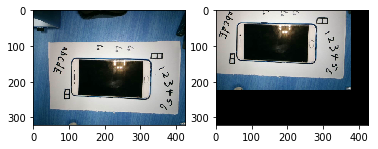

0


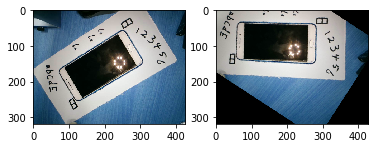

2
5
5


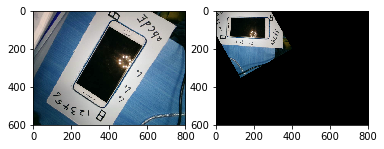

9
5
7


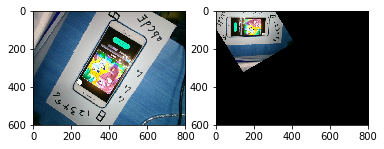

5
2
7


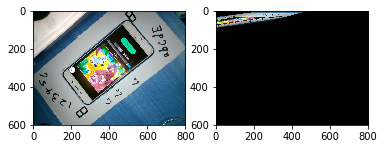

5
8
5
1


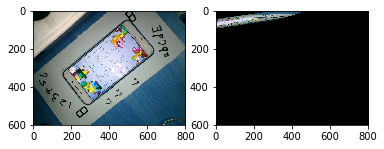

6
4
6
5


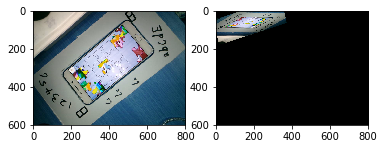

7


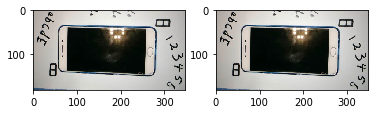

9
5
3
6


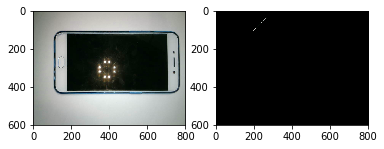

0
5
0
3


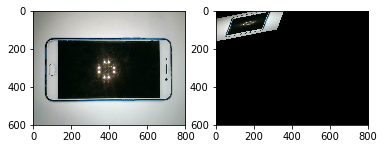

0
7
3
2


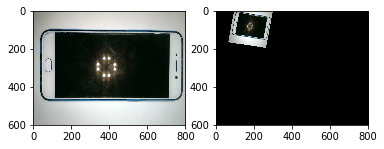

2
8
7
2


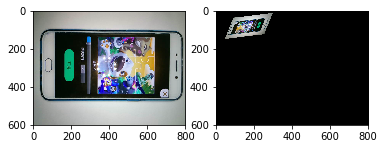

3
3
3
2


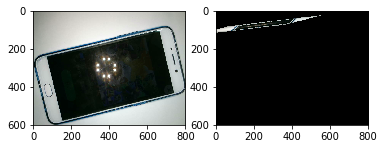

4
7
4
2


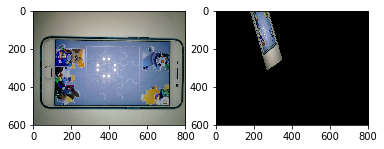

9
3
1
6


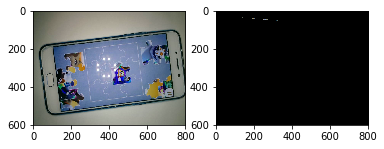

3
2
0
2


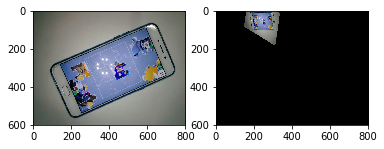

8
4
2
4


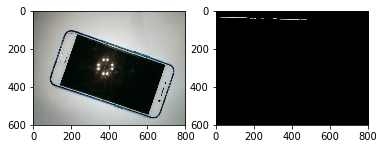

In [11]:
kernel = cv2.imread("pics/kernel.png")
toAllImg(TurnWindow)

# 基于轮廓的矫正

## 过程

In [3]:
from Cut import *

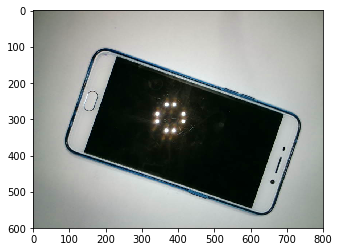

In [5]:
#以下图为例
image = cv2.imread('pics/new9.png')
plt.imshow(image)

边缘

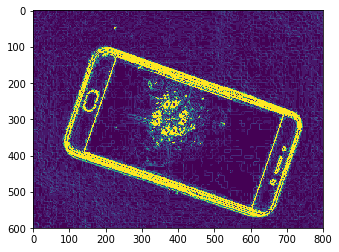

In [6]:

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)
plt.imshow(gradient)

阈值分割

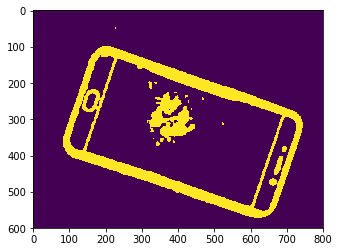

In [7]:
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 90, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)

得到边缘

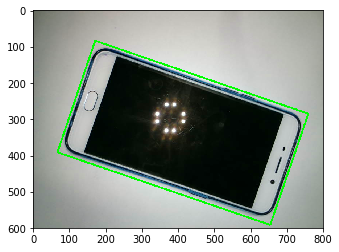

In [8]:
#(cnts, _) = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_con, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
c = sorted(contours, key=cv2.contourArea, reverse=True)[0]

# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))
# draw a bounding box arounded the detected barcode and display the image
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
plt.imshow(image)

依据边缘进行切割


In [9]:
#旋转
def rotate(img,center,angle):
    rows,cols,channel = img.shape
    M = cv2.getRotationMatrix2D((center[0],center[1]),angle,1)
    print(angle)
    dst = cv2.warpAffine(img,M,(cols,rows),borderValue=(255,255,255))
    return dst

In [10]:
#计算中心点
width = rect[1][0]
height = rect[1][1]
angle = rect[2]
if width < height:
        width,height = height,width
        angle = angle + 90
center = np.mean(box,axis = 0)
r = rotate(image,center,rect[2])
plt.subplot(1,2,1),plt.imshow(r,"gray")
## 裁剪

#width = np.sqrt(np.sum(np.square(box[0]-box[1])))
#height = np.sqrt(np.sum(np.square(box[0]-box[2])))
test = r[int(center[1]-height/2):int(center[1]+height/2),int(center[0]-width/2):int(center[0]+width/2)]
plt.subplot(1,2,2),
plt.imshow(test,"gray")
plt.show()

NameError: name 'center' is not defined

## 结果

0.0


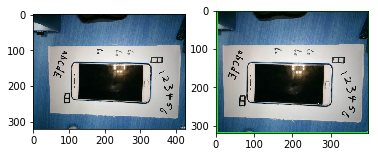

-33.310630798339844


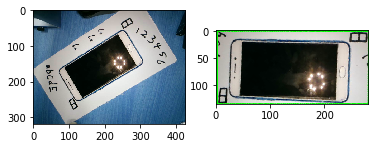

-59.973934173583984


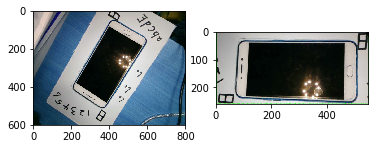

-60.104034423828125


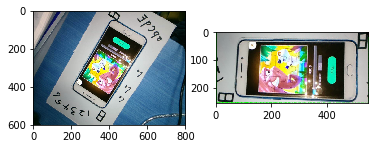

-41.084075927734375


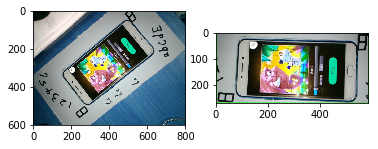

-41.009090423583984


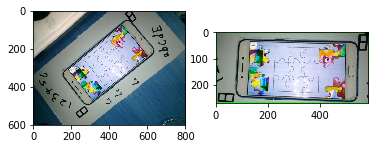

-41.21110916137695


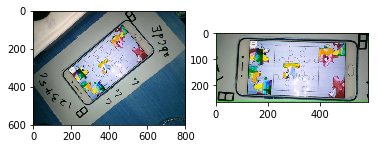

-0.0


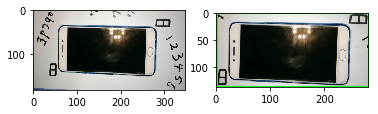

-0.0


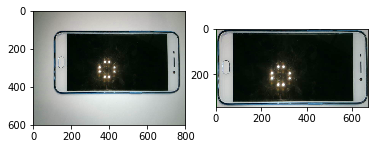

-0.0


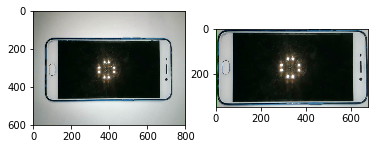

0.15484619140625


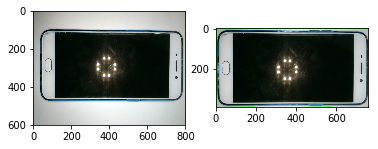

0.2747955322265625


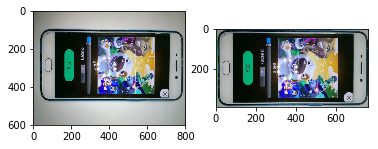

-13.864596366882324


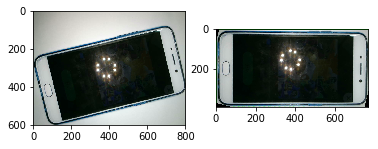

0.6227569580078125


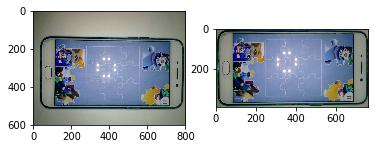

-7.26324462890625


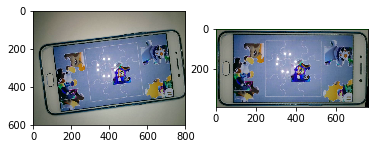

-23.850473403930664


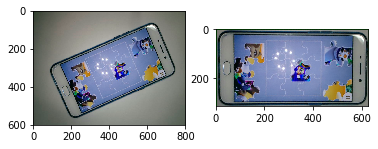

18.85315704345703


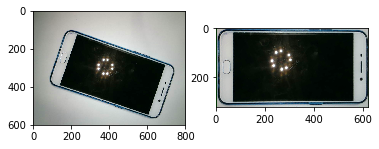

In [4]:
toAllImg(get_Contour)